In [1]:
import sys
import numpy as np
import import_ipynb
from scipy.sparse.linalg import spsolve
from pathlib import Path

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps  
    from fem_processing import boundary_conditions, matrices_assembly
    from fem_pos_processing import graph_results
    print("Modules imports were successful!")
except ModuleNotFoundError as key:
    print(f"Modules were not found: {key}")
except ImportError as key:
    print(f"Error in import: {key}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\05 GIT\PPGEE-2024.2-MEF
Todas as propriedades foram verificadas com sucesso para os elementos P1!
Todas as propriedades foram verificadas com sucesso para os elementos P2!
Todas as propriedades foram verificadas com sucesso para os elementos P3!
Todas as propriedades foram verificadas com sucesso para os elementos Q1!
Todas as propriedades foram verificadas com sucesso para os elementos Q2!
Modules imports were successful!


# Project 1: Poisson Problem at Rectangular Domain $\Omega = [0,1]^2$

Considere um problema de _Poisson_ 2D em $\Omega = [0,1]^2$

$$
-\nabla \cdot \left( \nabla u(x,y) \right) = f(x,y)
\tag{1}
$$

onde,
$$
f(x,y) = 2\pi^2 \, sin(\pi x) \, sin(\pi y)
\tag{2}
$$

cujas condições de contorno são $u=0$ em $\partial \Omega$.

A solução analítica deste problema é

$$
u(x,y) = sin(\pi x) \, sin(\pi y)
\tag{3}
$$

Implemente um programa de elementos finitos utilizando elementos triangulares $P_1$ para resolver o Problema de Valor de Contorno $(1)$.

# 3-noded Linear Triangular Elements, $P_1$
## Pre-processor module
### Geometry and mesh Domain

In [ ]:
FINITE_ELEMENT = ("Triangle", 1)
BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': 0.0, 'name': 'omega'}]
MATERIAL = [{'tag': 201, 'name': 'free_space', 'a_constant': 1}]

# Create mesh from file geometry
mesh_data = ps.create_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, h=0.02, view_mesh=False)

Model rectangular_domain (2D)
Info     : 9 geometric entities
Info     : 2 Physical Groups
Info     : 3013 nodes in total
Info     : 5824 2-D elements in total


### Figure 1: Rectangular meshed domain $\Omega=[0,1]^2$

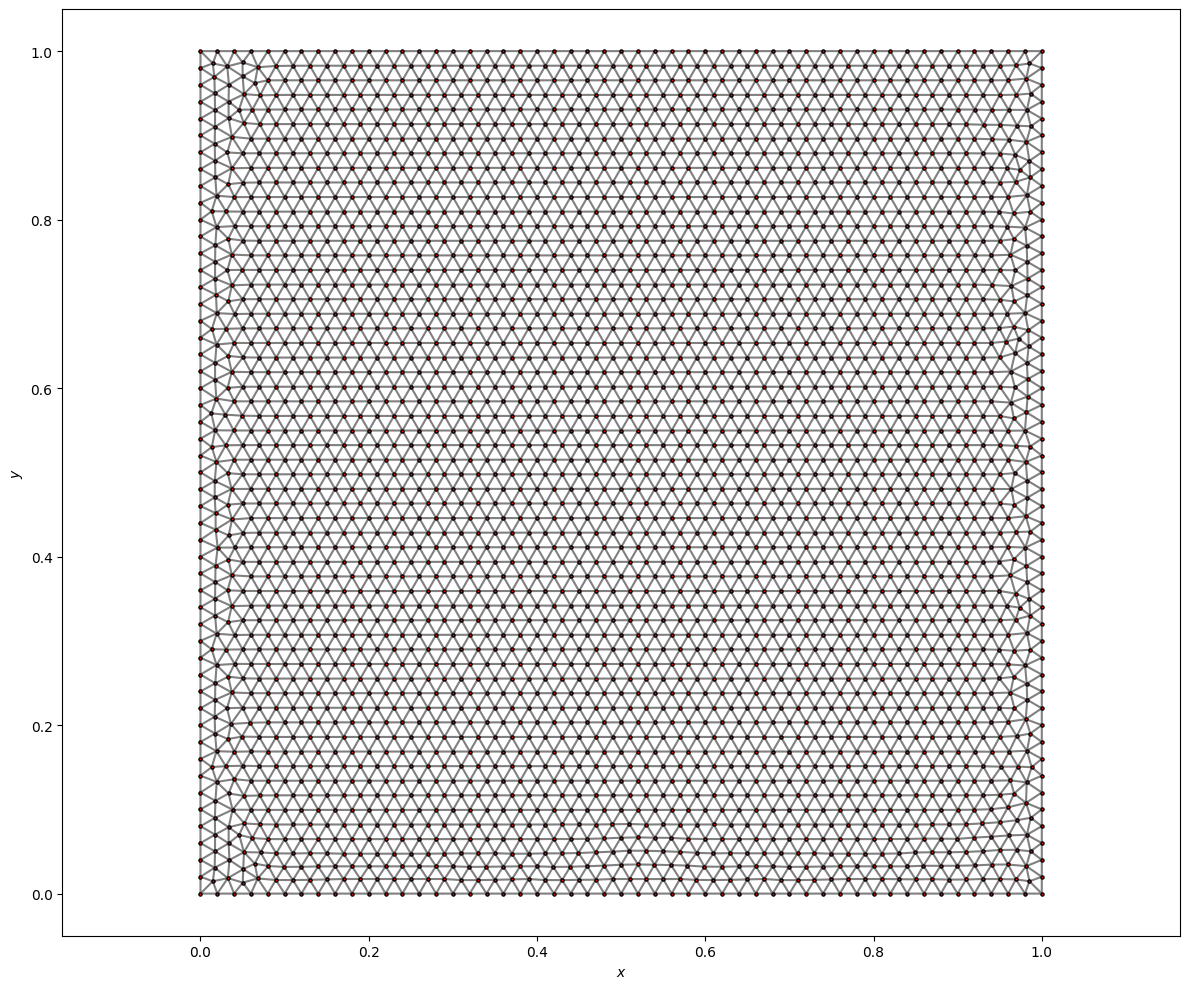

In [3]:
graph_results.plot_mesh(FINITE_ELEMENT, mesh_data, model='rectangular')

### Mesh Data Dictionaries

In [5]:
cell_data = mesh_data['cell']; cell_data[1]

{'conn': [2886, 1750, 2997],
 'std_conn': [1750, 2886, 2997],
 'edge_conn': [201, 202, 203],
 'material': {'tag': 201, 'name': 'free_space', 'a_constant': 1},
 'stiffness_term': [array([[1., 0.],
         [0., 1.]])],
 'mass_term': [1],
 'source': [1.0057787735261516],
 'abc': {'type': None, 'conn_idx': None}}

In [6]:
nodes_data = mesh_data['nodes']; nodes_data[1]

{'xg': (0.0, 0.0), 'bc': {'type': 'Dirichlet', 'value': 0.0}}

In [7]:
conn_data = {key: cell['conn'] for key, cell in cell_data.items()}; conn_data[1]

[2886, 1750, 2997]

### ``global_nodes_coordinates()``

In [8]:
nodes_coord = {key: value['xg'] for key, value in nodes_data.items()}; nodes_coord[1]

(0.0, 0.0)

### $x_g, y_g$ global coordinate

In [9]:
xg = {key: value['xg'][0] for key, value in nodes_data.items()}; xg[1]

0.0

### $a_e = (x_e, y_e)$ global element coordinate

In [10]:
aie = {key: [nodes_data[idx]['xg'] for idx in node_ids] for key, node_ids in conn_data.items()}; aie[1]

[(0.9822770422604864, 0.8290977806652943),
 (0.9598919009022603, 0.8268778375561322),
 (0.9663776086177377, 0.8073830225305368)]

In [11]:
print("'Node 1' global coordinates: "); nodes_data[1]['xg']

'Node 1' global coordinates: 


(0.0, 0.0)

In [12]:
xi = {key: [coord[0] for coord in coords] for key, coords in aie.items()}; xi[1]

[0.9822770422604864, 0.9598919009022603, 0.9663776086177377]

### Local Elements $e_1$

In [13]:
xi_master = (0, 1)
Je = matrices_assembly.jacobian(FINITE_ELEMENT, mesh_data, cell_data[1], xi_master) 
Jdet, Jinv = np.abs(np.linalg.det(Je)), np.linalg.inv(Je)
print("Jacobian matrix for element e_1:\n", Je)
print("Determinant of the Jacobian matrix for element e_1:", Jdet)
print("Inverse of the Jacobian matrix for element e_1:\n", Jinv)

Jacobian matrix for element e_1:
 [[-0.02238514 -0.00221994]
 [-0.01589943 -0.02171476]]
Determinant of the Jacobian matrix for element e_1: 0.00045079209225143565
Inverse of the Jacobian matrix for element e_1:
 [[-48.1702286    4.92453871]
 [ 35.26999234 -49.65735146]]


### Shape functions and derivatives

In [14]:
varphi, dN_dxi, dN_deta, grad_phi = matrices_assembly.derivatives_at_master_domain(FINITE_ELEMENT, xi_master)
print("Shape functions at master domain: \n", varphi)
print("Derivatives of the shape functions at master domain:\n", grad_phi)

Shape functions at master domain: 
 [[0]
 [0]
 [1]]
Derivatives of the shape functions at master domain:
 [[-1  1  0]
 [-1  0  1]]


### `map_to_physical_coordinates()`

In [15]:
xge, yge = matrices_assembly.isomapping_to_global_coordinates(FINITE_ELEMENT, aie[1], xi_master)
print(f"'e_1' Master coordinates: {xi_master} --> Global coordinates: ({xge}, {yge})")

'e_1' Master coordinates: (0, 1) --> Global coordinates: (0.9663776086177377, 0.8073830225305368)


### Material Proprieties, $k_a$

In [16]:
ka_e = mesh_data['cell'][1]['stiffness_term']
print("Stiffness matrix 'ka_e' for element e_1:\n", ka_e)

Stiffness matrix 'ka_e' for element e_1:
 [array([[1., 0.],
       [0., 1.]])]


### Matriz de rigidez

In [17]:
Be = Jinv @ grad_phi
print("Gradient matrix 'Be' for element e_1:\n", Be)

Gradient matrix 'Be' for element e_1:
 [[ 43.24568989 -48.1702286    4.92453871]
 [ 14.38735911  35.26999234 -49.65735146]]


### Local “stiffness” matrix, $A_e$

In [18]:
Ae, fe, _, _, _ = matrices_assembly.local_matrices(FINITE_ELEMENT, mesh_data, cell_data[1])
print("Local stiffness matrix for element e_1:\n", Ae)
print("Local load vector for element e_1:\n", fe)

Local stiffness matrix for element e_1:
 [[ 0.46818947+0.j -0.35515942+0.j -0.11303005+0.j]
 [-0.35515942+0.j  0.80338888+0.j -0.44822947+0.j]
 [-0.11303005+0.j -0.44822947+0.j  0.56125951+0.j]]
Local load vector for element e_1:
 [[7.55661878e-05]
 [7.55661855e-05]
 [7.55661855e-05]]


### Global “stiffness” matrix, $A_g$

In [19]:
Ag, fg, Mg, Pg, Qg = matrices_assembly.global_matrices(FINITE_ELEMENT, mesh_data)
print("Global matrix shape:", Ag.shape)

Global matrix shape: (3013, 3013)


### Boundary Conditions

In [20]:
dirichlet_nodes = {key: value 
                   for key, value in nodes_data.items() if value['bc']['type'] == 'Dirichlet'}
free_nodes = {key: value 
              for key, value in nodes_data.items() if value['bc']['type'] != 'Dirichlet'}

Nn = len(nodes_data)
Nd = len(dirichlet_nodes)
print(f"The entire domain has {Nn} nodes: {Nn - Nd} free nodes; {Nd} Dirichlet nodes.")

The entire domain has 3013 nodes: 2813 free nodes; 200 Dirichlet nodes.


### Mapping Global nodes to reduced system

This code creates a dictionary called ``global_to_reduced``, which maps the global indices of the mesh nodes to the reduced indices, i.e. the indices that correspond only to the nodes that are not in the _Dirichlet boundary conditions_.

In [21]:
mapping_global = {global_id: idx + 1 for idx, global_id in enumerate(free_nodes.keys())}

## Processor Module
### Asymmetric Global matrix $A_g$ with boundary conditions

In [22]:
Ag, fg = boundary_conditions.apply_simple_dirichlet(Ag, fg, mesh_data)
print("Global matrix shape:", Ag.shape)

Global matrix shape: (3013, 3013)


### Global Potential Vector

> Make sure Ag is in CSR format for efficiency  
> Convert fg to a dense format or keep it sparse as needed  
> Solve the linear system Ag * u = fg

In [23]:
ug = spsolve(Ag.tocsr(), fg.toarray())
print("Global Potencial Vector shape:", ug.shape)

Global Potencial Vector shape: (3013,)


### Reduced Global matrix $A_{gr}$ with boundary conditions

In [24]:
Agr, fgr, Mgr, Pgr, Qgr = boundary_conditions.reduced_global_matrices(FINITE_ELEMENT, mesh_data)
print("Reduced global matrix shape:", Agr.shape)

Reduced global matrix shape: (2813, 2813)


### Global Potential Solution

In [25]:
ur = spsolve(Agr.tocsr(), fgr.toarray())
potential_u = boundary_conditions.global_potentials_solution(mesh_data, ur)
print("Reduced Potencial Vector shape:", ur.shape)
print("Global Potencial Vector dimension:", len(potential_u))

Reduced Potencial Vector shape: (2813,)
Global Potencial Vector dimension: 3013


### Solution at each element

In [26]:
u_for_cell = {}
for key, cell in mesh_data['cell'].items():
    u_e = []
    for node in cell['conn']:
        u_e.append(potential_u[node])
    u_for_cell[key] = u_e

print("The complete solution for each cell."); u_for_cell[1]

The complete solution for each cell.


[(0.028388308354800027+0j),
 (0.06510571638724011+0j),
 (0.059928298058551877+0j)]

### Interpolate Solution at element, $e_n$

In [27]:
xi_master = (0, 0.5); 
u_at_node = matrices_assembly.isomapping_to_global_coordinates(FINITE_ELEMENT, u_for_cell[1], xi_master)
print(f"Element e_{key}: Potential 'u' interpolate at xi = {xi_master} --> u(xi): {u_at_node}")

Element e_5824: Potential 'u' interpolate at xi = (0, 0.5) --> u(xi): [0.0441583+0.j]


## Post-Processor

In [28]:
graph_results.fem_solution(FINITE_ELEMENT, mesh_data, potential_u, type='real')
graph_results.fem_griddata(FINITE_ELEMENT, mesh_data, potential_u, type='real')
ps.plot_analytical_solution(Npts=100)

Arquivo salvo em: c:\Users\adilt\OneDrive\05 GIT\PPGEE-2024.2-MEF\p11_poisson_problem\pos_processing\pictures\fem_solution_Triangle1.svg
Arquivo salvo em: c:\Users\adilt\OneDrive\05 GIT\PPGEE-2024.2-MEF\p11_poisson_problem\pos_processing\pictures\fem_solution_griddata_Triangle1.svg
Arquivo salvo em: c:\Users\adilt\OneDrive\05 GIT\PPGEE-2024.2-MEF\p11_poisson_problem\pos_processing\pictures\analytical_solution.svg


### Figure 2: Scalar Field Distribution on a Triangular Mesh
<figure>
    <img src="pos_processing/pictures/fem_solution_Triangle1.svg" alt="Fig.2" style="width:70%;" />
    <figcaption>Figure 2: Post-Processor: Scalar Field Distribution.</figcaption>
</figure>

### Figure 3: Scalar Field Distribution
<figure>
    <img src="pos_processing/pictures/fem_solution_griddata_Triangle1.svg" alt="Fig.3" style="width:70%;" />
    <figcaption>Figure 3: Post-Processor: Scalar Field Distribution and Triangular Mesh.</figcaption>
</figure>

### Figure 4: Analytical Scalar Field Distribution on a Triangular Mesh
<figure>
    <img src="pos_processing/pictures/analytical_solution.svg" alt="Fig.4" style="width:70%;" />
    <figcaption>Figure 4: Analytical Scalar Field Distribution on a Triangular Mesh.</figcaption>
</figure>

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2024.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.